# Pre-processing the data for modeling

## Objective

Transform data for modeling to ensure optimal prediction results and establish a baseline guide for what improvement looks like from a random guess or a model of unscaled data. Most importantly, we need to retain a test set of data the model has not seen to test it's performance on new information.  

## Considerations and future analysis

Too many Style categories make our data hard to visualize and model. The Style column is the only categorical feature we will use in our analysis as names and breweries of the beer will add too much noise. It is irrelavant to this anlysis of beer characteristics and how properties can predict beer ratings. In the future, names and breweries can be a separate analysis with text descriptions to explore sentiment and marketing impact on ratings. Integrating the two projects could yield some interstsing results on prediction. 

## Steps:
- Import data and packages.
- Cluster beer styles with Hierarchical Clustering solution and limit clusters to 10 or less
- Review cluster analysis to verify domain expertise in clustering
- Split data into train and test sets
- Run Dummy Regressor baseline model


## Import data and packages

In [1]:
# import previous data cleaning notebook
from IPython.utils import io
with io.capture_output() as captured:
    %run 2_EDA.ipynb

In [2]:
#import necessary packages
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.dummy import DummyRegressor
from scipy.cluster.vq import whiten
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

View unique beer styles in data.

In [3]:
beer_data['Style'].unique()

array(['Altbier', 'Barleywine - American', 'Barleywine - English',
       'Bitter - English Extra Special / Strong Bitter (ESB)',
       'Bitter - English', 'Bière de Champagne / Bière Brut',
       'Blonde Ale - American', 'Blonde Ale - Belgian',
       'Bock - Doppelbock', 'Bock - Eisbock', 'Bock - Maibock',
       'Bock - Traditional', 'Bock - Weizenbock', 'Braggot', 'Brett Beer',
       'Brown Ale - American', 'Brown Ale - Belgian Dark',
       'Brown Ale - English', 'California Common / Steam Beer',
       'Chile Beer', 'Cream Ale', 'Dubbel',
       'Farmhouse Ale - Bière de Garde', 'Farmhouse Ale - Sahti',
       'Farmhouse Ale - Saison', 'Fruit and Field Beer',
       'Gruit / Ancient Herbed Ale', 'Happoshu', 'Herb and Spice Beer',
       'IPA - American', 'IPA - Belgian',
       'IPA - Black / Cascadian Dark Ale', 'IPA - English',
       'IPA - Imperial', 'IPA - New England', 'Kvass', 'Kölsch',
       'Lager - Adjunct', 'Lager - American Amber / Red',
       'Lager - American',

From our histograms and summary statistics in the previous EDA, we see the range and scale of feature values is broad. Use normalization. 

In [4]:
# Normalize features used for clustering styles with whiten

beer_data['scaled_ABV'] = whiten(beer_data['ABV'])
beer_data['scaled_Min IBU'] = whiten(beer_data['Min IBU'])
beer_data['scaled_Max IBU'] = whiten(beer_data['Max IBU'])
beer_data['scaled_Astringency'] = whiten(beer_data['Astringency'])
beer_data['scaled_Body'] = whiten(beer_data['Body'])
beer_data['scaled_Alcohol'] = whiten(beer_data['Alcohol'])
beer_data['scaled_Bitter'] = whiten(beer_data['Bitter'])
beer_data['scaled_Sweet'] = whiten(beer_data['Sweet'])
beer_data['scaled_Sweet'] = whiten(beer_data['Sweet'])
beer_data['scaled_Sour'] = whiten(beer_data['Sour'])
beer_data['scaled_Salty'] = whiten(beer_data['Salty'])
beer_data['scaled_Fruits'] = whiten(beer_data['Fruits'])
beer_data['scaled_Hoppy'] = whiten(beer_data['Hoppy'])
beer_data['scaled_Spices'] = whiten(beer_data['Spices'])
beer_data['scaled_Malty'] = whiten(beer_data['Malty'])

Check again for missing values

In [5]:
beer_data.isnull().values.any()

False

In [6]:
beer_data.isna().any().any()

False

## Clustering Styles

Dendrogram - how to cluster into smaller categories

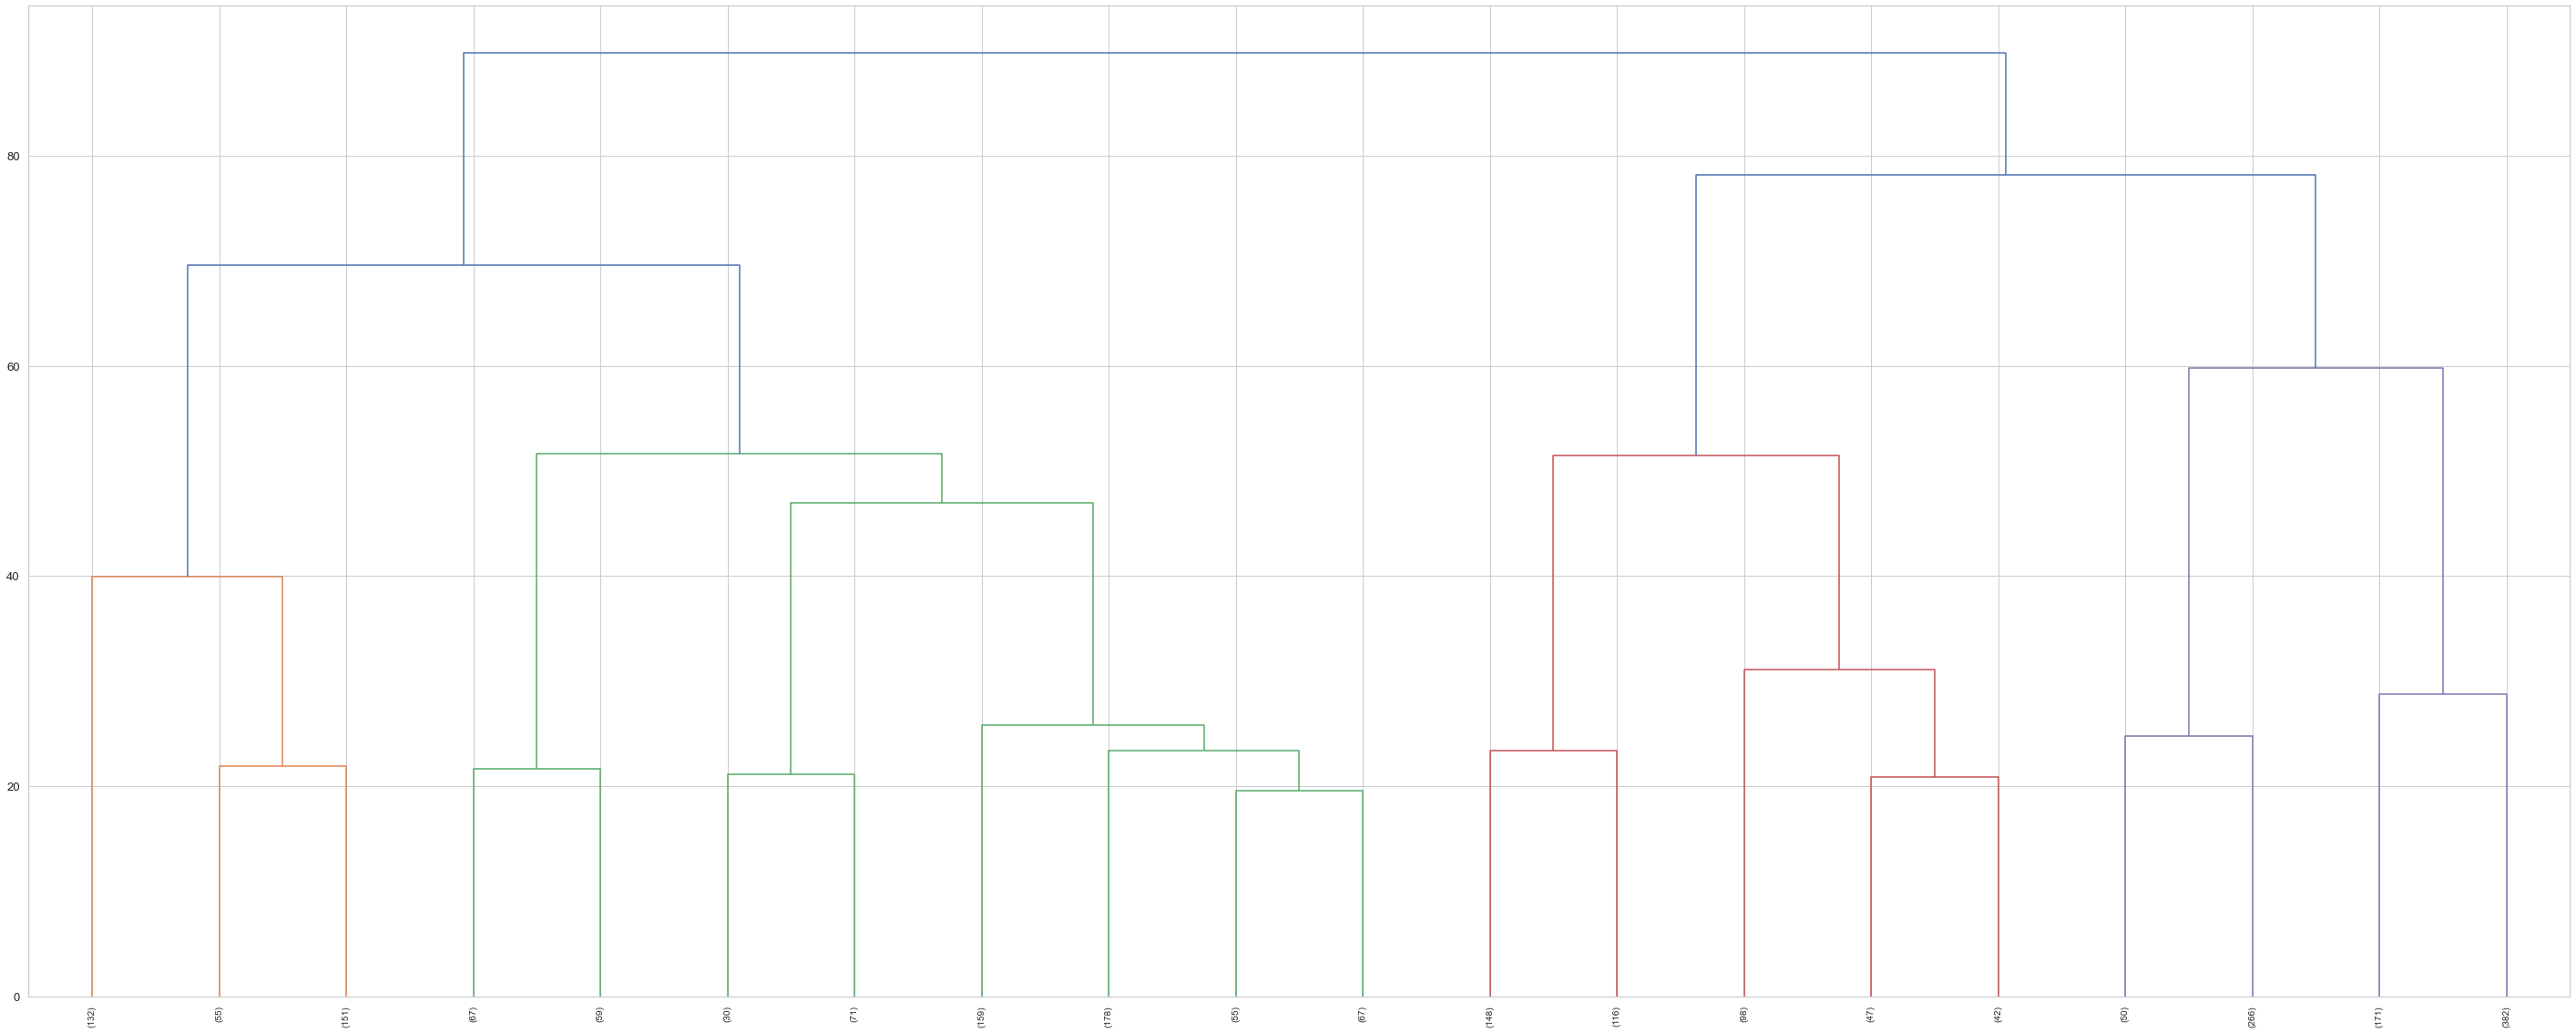

In [7]:
#Create dendrogram plot of Beer Styles to visualize clusters. 
#Select beer properties that are more recognizable by the average beer drinker; IBUs, ABV, Alcohol, Body, Bitter, Sweet, Hoppy, Spices, Malty, Fruist, Sour
#Use scaled features.
#Merge styles into new cluster labels.
#Try differnt cluster sizes and view results compared to intuitive clustering. 

plt.rcParams["figure.figsize"] = (50, 20)
#Create distance matrix for clusters
mergings = linkage(beer_data[['scaled_Max IBU','scaled_Min IBU','scaled_Alcohol', 'scaled_ABV', 'scaled_Body','scaled_Bitter','scaled_Sweet', 'scaled_Sour', 'scaled_Fruits', 
                              'scaled_Hoppy', 'scaled_Spices', 'scaled_Malty']].dropna().reset_index(drop=True), 
                   method='ward', metric='euclidean')
dendrogram(mergings, 
          labels=range(2344),
          leaf_rotation=90,
          leaf_font_size=10,
          truncate_mode='lastp',
           p=20)

#Assigning cluster labels
beer_data['cluster_labels'] = fcluster(mergings,7, criterion='maxclust')

plt.show()

In [8]:
#View dataframe with cluster labels
beer_data.head()

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,scaled_Alcohol,scaled_Bitter,scaled_Sweet,scaled_Sour,scaled_Salty,scaled_Fruits,scaled_Hoppy,scaled_Spices,scaled_Malty,cluster_labels
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,0.510664,1.849198,2.253117,0.927558,0.000000,1.028020,1.875695,0.357078,2.935702,7
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,1.021327,1.298373,1.674614,0.449725,0.000000,0.747651,1.151742,0.535617,2.221613,7
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,0.340442,1.652475,1.309244,0.309186,0.000000,0.311521,1.776974,0.178539,1.639762,7
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,1.758953,1.849198,3.075200,0.505941,0.450573,1.526454,1.316277,0.714156,3.147284,3
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,1.475251,1.731164,1.370139,0.252970,0.450573,0.342673,1.678253,0.892695,2.512538,7


Compare scaled data means with original data means

In [9]:
#Scaled cluster centers
print(beer_data.groupby('cluster_labels')[['scaled_Max IBU','scaled_Alcohol','scaled_Min IBU','scaled_ABV', 'scaled_Body', 'scaled_Bitter',
       'scaled_Sweet', 'scaled_Sour', 'scaled_Fruits', 'scaled_Hoppy', 'scaled_Spices', 'scaled_Malty']].mean())

                scaled_Max IBU  scaled_Alcohol  scaled_Min IBU  scaled_ABV  \
cluster_labels                                                               
1                     1.110177        0.635896        0.780737    2.544538   
2                     2.938884        3.828627        2.507044    5.000902   
3                     1.884685        1.518617        1.496779    3.317488   
4                     2.321055        0.609100        2.044001    2.504601   
5                     4.141584        1.513786        3.980689    4.012944   
6                     1.785594        0.626299        1.642442    2.489225   
7                     1.376420        0.444176        1.266966    2.161421   

                scaled_Body  scaled_Bitter  scaled_Sweet  scaled_Sour  \
cluster_labels                                                          
1                  1.419223       0.626255      1.778928     2.520807   
2                  2.734323       1.144742      3.395866     0.843681   
3    

In [10]:
#Oringinal cluster centers
print(beer_data.groupby('cluster_labels')[['Max IBU','Alcohol','Min IBU','ABV', 'Body', 'Bitter','Sweet', 'Sour',  'Fruits', 'Hoppy', 'Spices', 'Malty']].mean())

                  Max IBU    Alcohol    Min IBU        ABV       Body  \
cluster_labels                                                          
1               23.594675  11.207101  10.420118   5.893136  35.088757   
2               62.460317  67.476190  33.460317  11.582063  67.603175   
3               40.055357  26.764286  19.976786   7.683286  47.139286   
4               49.329545  10.734848  27.280303   5.800644  43.795455   
5               88.021390  26.679144  53.128342   9.293957  58.213904   
6               37.949367  11.037975  21.920886   5.765032  84.199367   
7               29.253165   7.828210  16.909584   5.005841  32.795660   

                   Bitter       Sweet       Sour     Fruits      Hoppy  \
cluster_labels                                                           
1               15.917160   58.426036  89.683432  79.183432  28.431953   
2               29.095238  111.531746  30.015873  58.047619  21.468254   
3               27.094643   78.953571  32.8464

How many observations are in each style? Is it balanced?

In [11]:
#Cluster sizes to verify cluster centers
print(beer_data.groupby('cluster_labels')['Style'].count())

cluster_labels
1    338
2    126
3    560
4    264
5    187
6    316
7    553
Name: Style, dtype: int64


Visualize the property makeup of the new clusters.

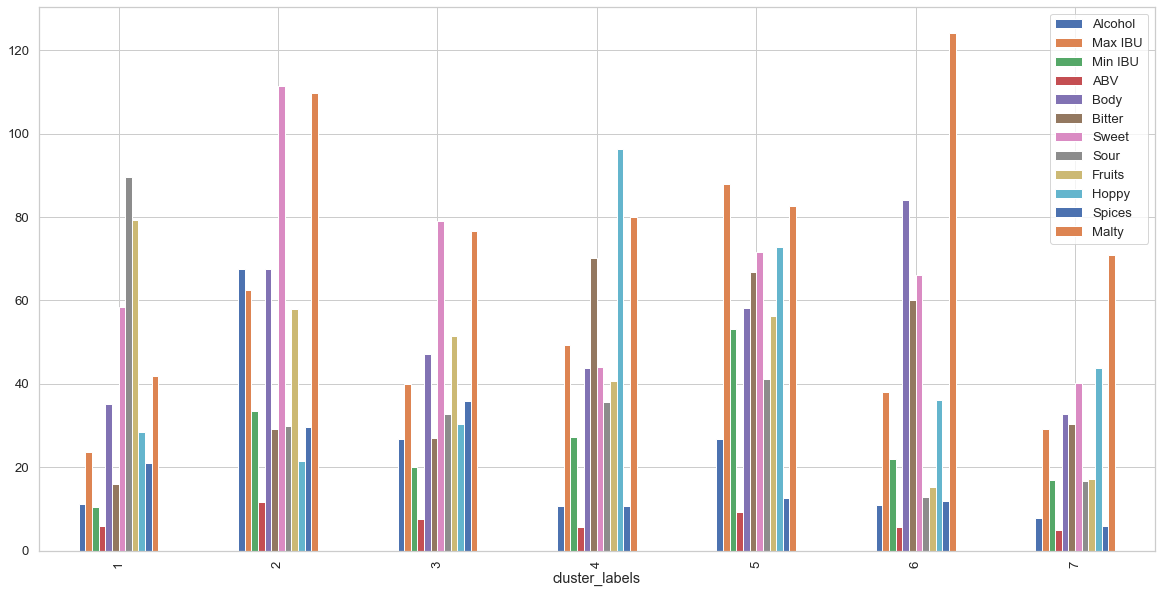

In [12]:
#Plot cluster centers to visualize attributes of each cluster

plt.rcParams["figure.figsize"] = (20, 10)
beer_data.groupby('cluster_labels')[['Alcohol','Max IBU','Min IBU', 'ABV', 'Body', 'Bitter',
       'Sweet', 'Sour', 'Fruits', 'Hoppy', 'Spices', 'Malty']].mean().plot(kind='bar')

plt.show()

## Observations(10 Clusters):
- Cluster 1 = Most sour
- Cluster 2 = Higher fruits, sours and malts but not highest in any property
- Cluster 3 = Highest sweetness.
- Cluster 4 = Highest alcohol conents. Higher IBU
- Cluster 5 = Higher sweetness and IBU but not the highest in any property
- Cluster 6 = Highest hops and higher IBU, not highest IBU. 
- Cluster 7 = High hops and IBU but not the highest. 
- Cluster 8 = Highest malts, Highest IBUs.
- Cluster 9 = Highest malts, highest body
- Cluster 10 = Lowest ABV

- Alcohol = High = 4 | Low = 10
- Max IBU = High = 8| Low = 1
- Min IBU = High low = 7 | Low low = 1 & 2
- ABV: High = 3 | Low = 10
- Body = High = 9 | Low = 1
- Biter = High = 6 & 7 | Low = 1
- Sweet = High = 3 | Low = 10
- Sour = High = 1 | Low = 9
- Fruits = High = 1 | Low = 9
- Hoppy = High = 6 | Low = 1
- Spices = High = 4 | Low = 10
- Malty = High = 9 | Low = 1

## Observations(7 Clusters):
- Cluster 1 = Highest sours and fruits - Fruit_Sour - Sour
- Cluster 2 = Hihgest malts and sweets, lowest hoppy - Malts_Wheats - Sweet_Malts
- Cluster 3 = Second highes sweets. Moderate propeties. - Heavy_moderate - Seasonal
- Cluster 4 = Highest hops and bitterness and max IBU -Heavy 
- Cluster 5 = Highest malts and body, lowest sour  - Dark
- Cluster 6 = Lowest ABV and spices - Light
- Cluster 7 = Lowest Alcohol
- Alcohol = High = 2 | Low = 6
- Max IBU = High = 4| Low = 1
- Min IBU = High low = 1 | Low low = 4
- ABV: High = 2 | Low = 6
- Body = High = 5 | Low = 6
- Biter = High = 4 | Low = 1
- Sweet = High = 2 | Low = 6
- Sour = High = 1 | Low = 5
- Fruits = High = 1 | Low = 5
- Hoppy = High = 4 | Low = 2
- Spices = High = 3 | Low = 6
- Malty = High = 5 | Low = 1

What styles are in each cluster?

Sour_Fruits

In [13]:
print(beer_data[beer_data['cluster_labels'] == 1]['Style'].unique())

['Bière de Champagne / Bière Brut' 'Blonde Ale - Belgian'
 'Bock - Weizenbock' 'Brett Beer' 'Brown Ale - Belgian Dark' 'Cream Ale'
 'Farmhouse Ale - Bière de Garde' 'Farmhouse Ale - Sahti'
 'Farmhouse Ale - Saison' 'Fruit and Field Beer'
 'Gruit / Ancient Herbed Ale' 'Herb and Spice Beer' 'Kvass'
 'Lager - Light' 'Lambic - Faro' 'Lambic - Fruit' 'Lambic - Gueuze'
 'Lambic - Traditional' 'Pale Ale - Belgian' 'Porter - English'
 'Rye Beer - Roggenbier' 'Sour - Berliner Weisse'
 'Sour - Flanders Oud Bruin' 'Sour - Flanders Red Ale' 'Sour - Gose'
 'Strong Ale - Belgian Dark' 'Strong Ale - Belgian Pale'
 'Wheat Beer - American Pale' 'Wheat Beer - Dunkelweizen'
 'Wheat Beer - Hefeweizen' 'Wheat Beer - Kristallweizen'
 'Wheat Beer - Witbier' 'Wild Ale']


Sweet_Malts

In [14]:
print(beer_data[beer_data['cluster_labels'] == 2]['Style'].unique())

['Barleywine - American' 'Barleywine - English'
 'Bière de Champagne / Bière Brut' 'Bock - Doppelbock' 'Bock - Eisbock'
 'Bock - Maibock' 'Fruit and Field Beer' 'Herb and Spice Beer'
 'Lager - Schwarzbier' 'Old Ale' 'Pilsner - Imperial' 'Porter - Baltic'
 'Porter - Imperial' 'Porter - Robust' 'Pumpkin Beer' 'Quadrupel (Quad)'
 'Rye Beer' 'Scotch Ale / Wee Heavy' 'Scottish Ale' 'Smoked Beer'
 'Stout - American Imperial' 'Stout - Oatmeal' 'Stout - Russian Imperial'
 'Strong Ale - American' 'Strong Ale - Belgian Dark'
 'Strong Ale - Belgian Pale' 'Strong Ale - English' 'Tripel'
 'Wheat Beer - Wheatwine' 'Winter Warmer']


Strong_Moderate_Seaonal

In [15]:
print(beer_data[beer_data['cluster_labels'] == 3]['Style'].unique())

['Altbier' 'Barleywine - English' 'Bière de Champagne / Bière Brut'
 'Blonde Ale - Belgian' 'Bock - Doppelbock' 'Bock - Maibock'
 'Bock - Traditional' 'Bock - Weizenbock' 'Braggot' 'Brown Ale - American'
 'Brown Ale - Belgian Dark' 'Brown Ale - English' 'Chile Beer' 'Cream Ale'
 'Dubbel' 'Farmhouse Ale - Bière de Garde' 'Farmhouse Ale - Sahti'
 'Farmhouse Ale - Saison' 'Fruit and Field Beer'
 'Gruit / Ancient Herbed Ale' 'Herb and Spice Beer'
 'Lager - American Amber / Red' 'Lager - American' 'Lager - European Dark'
 'Lager - European Strong' 'Lager - Helles' 'Lager - Malt Liquor'
 'Lager - Märzen / Oktoberfest' 'Lager - Rauchbier' 'Lager - Vienna'
 'Mild Ale - English Dark' 'Old Ale' 'Pale Ale - Belgian'
 'Pale Ale - English' 'Pilsner - Imperial' 'Porter - American'
 'Porter - Baltic' 'Porter - Imperial' 'Porter - Smoked' 'Pumpkin Beer'
 'Quadrupel (Quad)' 'Red Ale - Irish' 'Rye Beer' 'Scotch Ale / Wee Heavy'
 'Scottish Ale' 'Smoked Beer' 'Stout - American Imperial'
 'Stout - American

Ale

In [16]:
print(beer_data[beer_data['cluster_labels'] == 4]['Style'].unique())

['Altbier' 'Bitter - English Extra Special / Strong Bitter (ESB)'
 'Bitter - English' 'Blonde Ale - American' 'Bock - Maibock'
 'Brown Ale - American' 'California Common / Steam Beer'
 'Herb and Spice Beer' 'IPA - American' 'IPA - Belgian'
 'IPA - Black / Cascadian Dark Ale' 'IPA - English' 'Kölsch'
 'Lager - American Amber / Red' 'Lager - American'
 'Lager - European / Dortmunder Export' 'Lager - European Strong'
 'Lager - Helles' 'Lager - India Pale Lager (IPL)'
 'Lager - Kellerbier / Zwickelbier' 'Lager - Vienna' 'Low Alcohol Beer'
 'Mild Ale - English Pale' 'Pale Ale - American' 'Pale Ale - Belgian'
 'Pale Ale - English' 'Pilsner - Bohemian / Czech' 'Pilsner - German'
 'Pilsner - Imperial' 'Porter - American' 'Porter - Imperial'
 'Red Ale - American Amber / Red' 'Red Ale - Imperial' 'Rye Beer'
 'Scottish Ale' 'Stout - American Imperial' 'Stout - Foreign / Export'
 'Stout - Irish Dry' 'Stout - Russian Imperial'
 'Wheat Beer - American Dark' 'Wheat Beer - American Pale' 'Winter Warme

Heavy 

In [17]:
print(beer_data[beer_data['cluster_labels'] == 5]['Style'].unique())

['Barleywine - American' 'IPA - American' 'IPA - Belgian'
 'IPA - Black / Cascadian Dark Ale' 'IPA - English' 'IPA - Imperial'
 'IPA - New England' 'Lager - India Pale Lager (IPL)' 'Pilsner - Imperial'
 'Red Ale - Imperial' 'Stout - American Imperial'
 'Stout - Russian Imperial' 'Strong Ale - American'
 'Wheat Beer - Wheatwine' 'Winter Warmer']


Stout

In [18]:
print(beer_data[beer_data['cluster_labels'] == 6]['Style'].unique())

['Altbier' 'Bitter - English' 'Bock - Doppelbock' 'Bock - Traditional'
 'Brown Ale - American' 'Brown Ale - Belgian Dark' 'Brown Ale - English'
 'California Common / Steam Beer' 'Cream Ale' 'Gruit / Ancient Herbed Ale'
 'Lager - European / Dortmunder Export' 'Lager - European Dark'
 'Lager - Munich Dunkel' 'Lager - Märzen / Oktoberfest'
 'Lager - Schwarzbier' 'Lager - Vienna' 'Mild Ale - English Dark'
 'Old Ale' 'Pale Ale - English' 'Porter - American' 'Porter - Baltic'
 'Porter - English' 'Porter - Imperial' 'Porter - Robust'
 'Red Ale - Irish' 'Rye Beer' 'Scotch Ale / Wee Heavy' 'Scottish Ale'
 'Stout - American' 'Stout - English' 'Stout - Foreign / Export'
 'Stout - Irish Dry' 'Stout - Oatmeal' 'Stout - Sweet / Milk'
 'Strong Ale - Belgian Dark' 'Wheat Beer - American Dark' 'Winter Warmer']


Light

In [19]:
print(beer_data[beer_data['cluster_labels'] == 7]['Style'].unique())

['Altbier' 'Bitter - English Extra Special / Strong Bitter (ESB)'
 'Bitter - English' 'Blonde Ale - American' 'Bock - Maibock'
 'Bock - Traditional' 'Brown Ale - American' 'Brown Ale - English'
 'California Common / Steam Beer' 'Cream Ale'
 'Farmhouse Ale - Bière de Garde' 'Happoshu' 'IPA - English' 'Kölsch'
 'Lager - Adjunct' 'Lager - American Amber / Red' 'Lager - American'
 'Lager - European / Dortmunder Export' 'Lager - European Dark'
 'Lager - European Pale' 'Lager - European Strong' 'Lager - Helles'
 'Lager - Japanese Rice' 'Lager - Kellerbier / Zwickelbier'
 'Lager - Light' 'Lager - Malt Liquor' 'Lager - Munich Dunkel'
 'Lager - Märzen / Oktoberfest' 'Lager - Schwarzbier' 'Lager - Vienna'
 'Low Alcohol Beer' 'Mild Ale - English Dark' 'Mild Ale - English Pale'
 'Pale Ale - American' 'Pale Ale - English' 'Pilsner - Bohemian / Czech'
 'Pilsner - German' 'Pilsner - Imperial' 'Porter - American'
 'Porter - Baltic' 'Porter - English' 'Porter - Smoked'
 'Red Ale - American Amber / Red'

print(beer_data[beer_data['cluster_labels'] == 8]['Style'].unique())

print(beer_data[beer_data['cluster_labels'] == 9]['Style'].unique())

print(beer_data[beer_data['cluster_labels'] == 10]['Style'].unique())

In [20]:
# Verify encoded cluster labels 
dummy  = pd.get_dummies(beer_data['cluster_labels'])
print(dummy)

      1  2  3  4  5  6  7
0     0  0  0  0  0  0  1
1     0  0  0  0  0  0  1
2     0  0  0  0  0  0  1
3     0  0  1  0  0  0  0
4     0  0  0  0  0  0  1
...  .. .. .. .. .. .. ..
3190  0  0  1  0  0  0  0
3191  0  0  1  0  0  0  0
3193  0  0  1  0  0  0  0
3194  0  0  1  0  0  0  0
3195  0  0  0  0  1  0  0

[2344 rows x 7 columns]


In [21]:
# Verifty add the encoding to the dataframe 
beer_data = pd.concat([beer_data, dummy], axis=1)
beer_data.head()

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,scaled_Spices,scaled_Malty,cluster_labels,1,2,3,4,5,6,7
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,0.357078,2.935702,7,0,0,0,0,0,0,1
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,0.535617,2.221613,7,0,0,0,0,0,0,1
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,0.178539,1.639762,7,0,0,0,0,0,0,1
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,0.714156,3.147284,3,0,0,1,0,0,0,0
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,0.892695,2.512538,7,0,0,0,0,0,0,1


Rename cluster columns based on quick analysis

In [22]:
#Inputing meaninful new cluster column names.
beer_data.rename(columns = {1:'Style_Sour_Fruits', 2:'Style_Sweet_Malts', 3:'Style_Strong_Moderate_Seaonal', 4:'Style_Ale', 5:'Style_Heavy', 6:'Style_Dark', 7:'Style_Light' }, inplace = True)


In [23]:
beer_data.head()

,Name,Style,Brewery,Beer Name (Full),Description,ABV,Min IBU,Max IBU,Astringency,Body,...,scaled_Spices,scaled_Malty,cluster_labels,Style_Sour_Fruits,Style_Sweet_Malts,Style_Strong_Moderate_Seaonal,Style_Ale,Style_Heavy,Style_Dark,Style_Light
0,Amber,Altbier,Alaskan Brewing Co.,Alaskan Brewing Co. Alaskan Amber,"Notes:Richly malty and long on the palate, wit...",5.3,25,50,13,32,...,0.357078,2.935702,7,0,0,0,0,0,0,1
1,Double Bag,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Double Bag,"Notes:This malty, full-bodied double alt is al...",7.2,25,50,12,57,...,0.535617,2.221613,7,0,0,0,0,0,0,1
2,Long Trail Ale,Altbier,Long Trail Brewing Co.,Long Trail Brewing Co. Long Trail Ale,Notes:Long Trail Ale is a full-bodied amber al...,5.0,25,50,14,37,...,0.178539,1.639762,7,0,0,0,0,0,0,1
3,Doppelsticke,Altbier,Uerige Obergärige Hausbrauerei GmbH / Zum Uerige,Uerige Obergärige Hausbrauerei GmbH / Zum Ueri...,Notes:,8.5,25,50,13,55,...,0.714156,3.147284,3,0,0,1,0,0,0,0
4,Sleigh'r Dark Doüble Alt Ale,Altbier,Ninkasi Brewing Company,Ninkasi Brewing Company Sleigh'r Dark Doüble A...,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,25,50,25,51,...,0.892695,2.512538,7,0,0,0,0,0,0,1


In [24]:
beer_data.columns = beer_data.columns.map(str)

## Baseline Model - Dummy Regressor

In [25]:
#Check the length of the data frame and see what the size of the training and test sets will be. 

len(beer_data), len(beer_data)*.80 , len(beer_data)*.20

(2344, 1875.2, 468.8)

In [26]:
#Split the dataframe into X_train, X_test, y_train, y_test sets 
#Removing the target feature from the X axis and subsetting the target feature for the Y axis.
#Make the test sets sized 25% of original dataframe. 

X_train, X_test, y_train, y_test = train_test_split(beer_data.drop(columns='review_overall'), beer_data.review_overall, test_size=0.25, random_state=36)

In [27]:
# Make a list of all the columns to remove from the analysis. 
# Categorical data to ignore for now, scaled data from cluster analysis to prevent leakage and sub categories of reviews
# using the that are in direct correlation of the rating_overal  

names_list = ['Name', 'Style', 'Brewery', 'Beer Name (Full)', 'Description', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'number_of_reviews','scaled_ABV', 'scaled_Min IBU', 'scaled_Max IBU','scaled_Astringency', 'scaled_Body', 'scaled_Alcohol', 'scaled_Bitter',
       'scaled_Sweet', 'scaled_Sour', 'scaled_Salty', 'scaled_Fruits', 'scaled_Hoppy', 'scaled_Spices', 'scaled_Malty', 'cluster_labels']


In [28]:
# Remove the list of columns we do not need for analysis from X train & test sets. Y is already set to target variable. 

names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((1758, 21), (586, 21))

In [29]:
# Convert all columns in the separate sets to float data types. 

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

In [30]:
#View size and shape of data sets

X_train.shape, X_test.shape

((1758, 21), (586, 21))

In [31]:
y_train.shape, y_test.shape

((1758,), (586,))

In [32]:
#Check data types in the sets

X_train.dtypes

ABV                              float64
Min IBU                          float64
Max IBU                          float64
Astringency                      float64
Body                             float64
Alcohol                          float64
Bitter                           float64
Sweet                            float64
Sour                             float64
Salty                            float64
Fruits                           float64
Hoppy                            float64
Spices                           float64
Malty                            float64
Style_Sour_Fruits                float64
Style_Sweet_Malts                float64
Style_Strong_Moderate_Seaonal    float64
Style_Ale                        float64
Style_Heavy                      float64
Style_Dark                       float64
Style_Light                      float64
dtype: object

In [33]:
X_test.dtypes

ABV                              float64
Min IBU                          float64
Max IBU                          float64
Astringency                      float64
Body                             float64
Alcohol                          float64
Bitter                           float64
Sweet                            float64
Sour                             float64
Salty                            float64
Fruits                           float64
Hoppy                            float64
Spices                           float64
Malty                            float64
Style_Sour_Fruits                float64
Style_Sweet_Malts                float64
Style_Strong_Moderate_Seaonal    float64
Style_Ale                        float64
Style_Heavy                      float64
Style_Dark                       float64
Style_Light                      float64
dtype: object

In [34]:
y_train.dtypes

dtype('float64')

In [35]:
y_test.dtypes

dtype('float64')

In [36]:
# check the mean of the target variable in the train set as a "best guess" for accuracy. 
train_mean = y_train.mean()
train_mean

3.760318823663254

In [37]:
# Fit the dummy regressor on the training data to calculate baseline results.
# Draw comparison between Dummy Regression and Linear Regerssion. 
# Predict target values without any influence of the training data
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[3.76031882]])

Dummy regressor constant attribute is the same as the best guess mean. Benchmark for performance.

View Metrics of baseline results. 

In [38]:
#Calculate R^2
def r_squared(y_train, y_test):
    ybar = np.sum(y_train) / len(y_train)
    sum_sq_tot = np.sum((y_train - ybar)**2) #total sum of squares error
    sum_sq_res = np.sum((y_train - y_test)**2) #residual sum of squares error
    R2 = 1.0 - sum_sq_tot / sum_sq_res
    return R2

In [39]:
# Make predictions on training set using mean. 
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([3.76031882, 3.76031882, 3.76031882, 3.76031882, 3.76031882])

In [40]:
# Prediction gives R^2 of 0 on training set.
r_squared(y_train, y_tr_pred)

0.0

In [41]:
y_te_pred = train_mean * np.ones(len(y_test))

In [42]:
r_squared(y_test, y_te_pred)

0.001718924972636815

In [43]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0017218847633564405)

In [44]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)


(0.30288678107167494, 0.28556960858988845)

In [45]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)


(0.1760975378068062, 0.14767043936997545)

## Finalize pre-processing and scaling data for modeling

In [46]:
#impute any missing values with the mean just in case. 
X_defaults_mean = X_train.mean()
X_defaults_mean

ABV                               6.661490
Min IBU                          22.521047
Max IBU                          41.055176
Astringency                      17.120592
Body                             48.832196
Alcohol                          18.358362
Bitter                           39.063140
Sweet                            62.462457
Sour                             34.880546
Salty                             1.068828
Fruits                           41.428896
Hoppy                            44.625711
Spices                           18.637656
Malty                            80.441411
Style_Sour_Fruits                 0.145051
Style_Sweet_Malts                 0.055176
Style_Strong_Moderate_Seaonal     0.237201
Style_Ale                         0.112059
Style_Heavy                       0.081342
Style_Dark                        0.129124
Style_Light                       0.240046
dtype: float64

In [47]:
#Apply imputation to train and test test splits
X_tr = X_train.fillna(X_defaults_mean)
X_te = X_test.fillna(X_defaults_mean)

In [48]:
#Standardize the data to rescale for modeling

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)